# Deposition Environment Classifier

In [ ]:
# ploting, dataframe, and numerical operation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from plotfunc import envplot_data, envplot_val, envplot_test

# dataset splitting
from sklearn.model_selection import train_test_split

# training
!pip install jcopml
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease
from sklearn.metrics import f1_score, classification_report

# evaluation
from jcopml.plot import plot_confusion_matrix, plot_classification_report, plot_actual_vs_prediction

# feature engineering
from jcopml.feature_importance import mean_score_decrease as msd

## Data loading

In [ ]:
df = pd.read_csv("env_train.csv")

df = df.replace([-999.25, df['GR'].max()], np.nan)

df.head()

,Depth,Well,Formation,GR,NPHI,RHOB,DTCO,DTSM,Environment
0,4600.0,P-2,Jamieson Fm,66.4510,13.8882,2.5715,81.8708,NaN,4
1,4600.5,P-2,Jamieson Fm,54.4524,12.1851,2.5604,78.5466,NaN,4
2,4601.0,P-2,Jamieson Fm,51.3234,12.0860,2.5458,81.6343,NaN,4
3,4601.5,P-2,Jamieson Fm,49.2121,11.5609,2.5479,78.2709,NaN,4
4,4602.0,P-2,Jamieson Fm,68.4992,15.9469,2.5307,79.5989,NaN,4


## Data statistics

In [ ]:
df.describe()

,Depth,GR,NPHI,RHOB,DTCO,DTSM,Environment
count,2995.000000,2752.000000,2905.000000,2829.000000,2663.000000,2468.000000,2995.000000
mean,4962.672287,66.165314,20.972374,2.654081,68.878980,121.471750,2.778631
std,216.569096,35.172555,10.996101,0.119257,9.306656,22.403778,1.343013
min,4577.000000,5.377100,2.085300,1.525400,42.793000,69.261800,0.000000
25%,4775.500000,34.857950,11.536800,2.629200,62.438000,103.399550,2.000000
50%,4962.500000,65.585350,20.416900,2.674400,67.129600,117.314650,2.000000
75%,5149.750000,92.777125,27.419500,2.711300,75.134050,136.881475,4.000000
max,5351.000000,171.265700,82.672200,3.157100,179.561400,234.866500,5.000000


In [ ]:
df.Environment.value_counts()

2    1648
5     536
4     443
3     145
1     139
0      84
Name: Environment, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


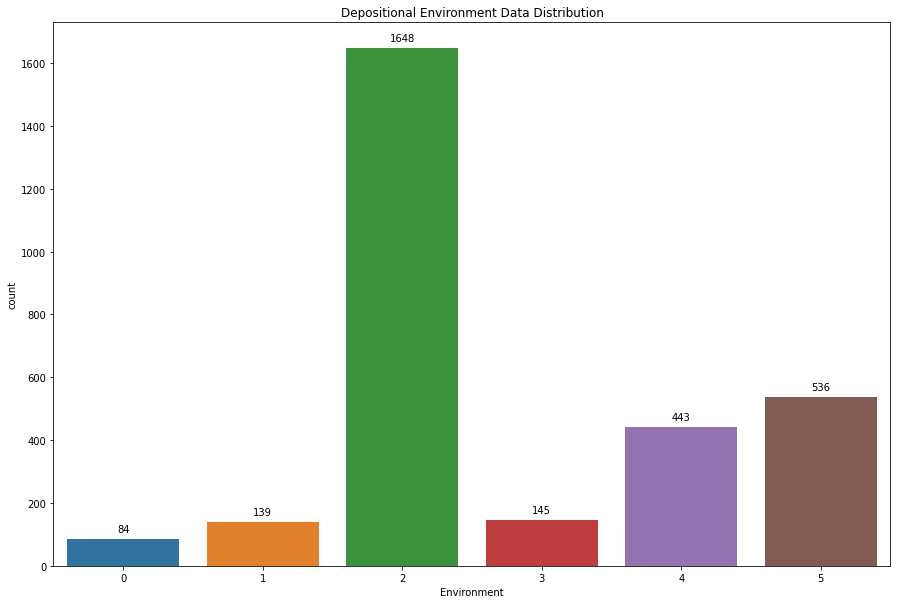

In [ ]:
plt.figure(figsize = (15, 10))

envplot = sns.countplot(df.Environment);

for i in envplot.patches:
    envplot.annotate(format(i.get_height()), (i.get_x() + i.get_width() / 2., i.get_height()), 
                     ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title('Depositional Environment Data Distribution')

plt.savefig('env_distribution.png')

plt.show()

## Missing values checking

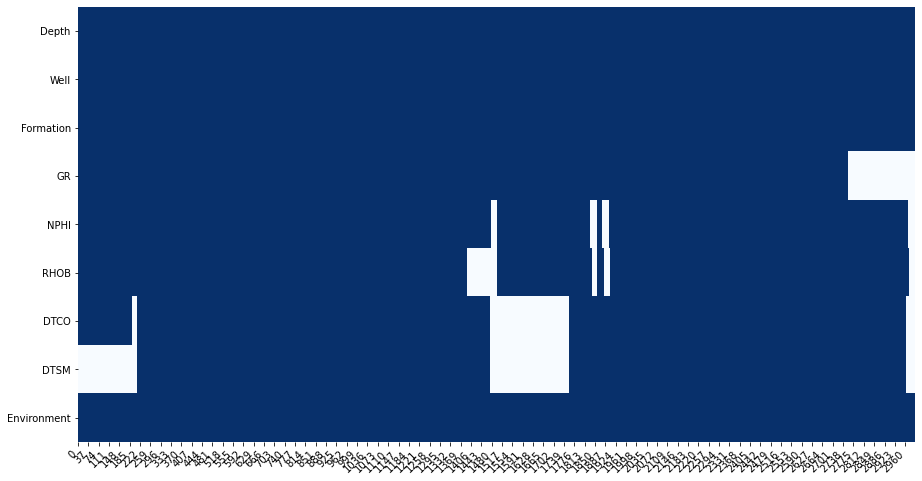

In [ ]:
plot_missing_value(df)

## Training data plotting

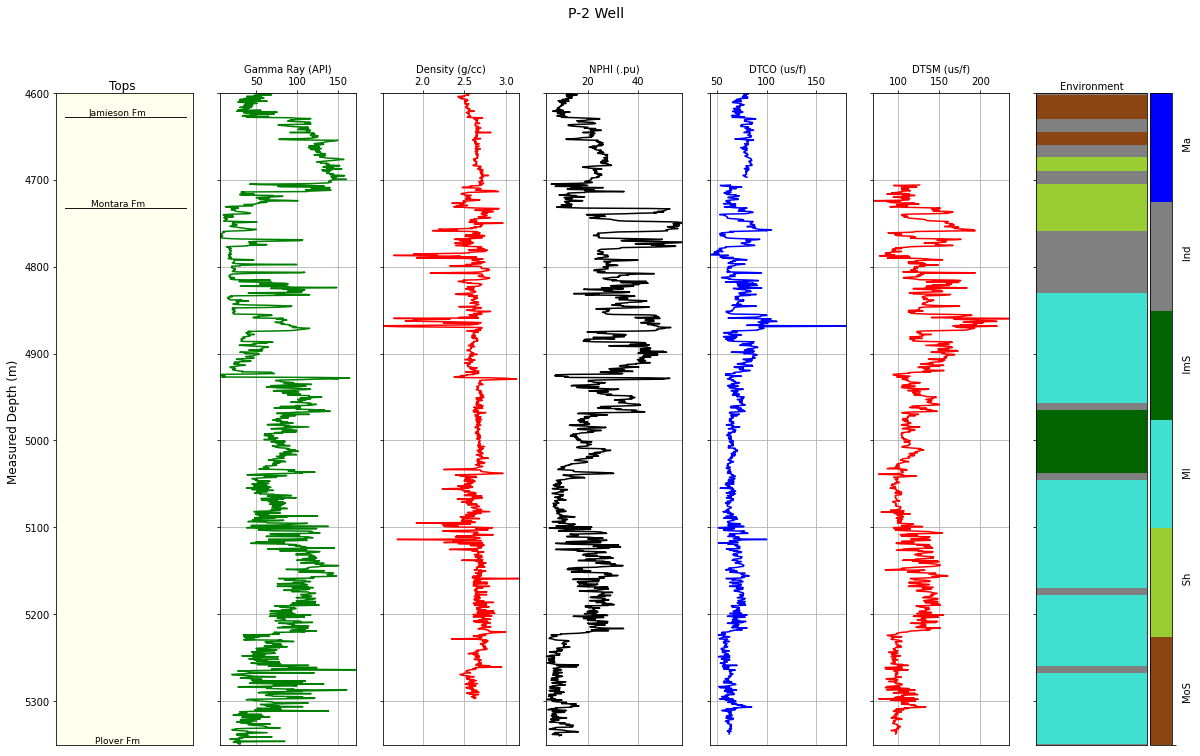

In [ ]:
envplot_data(df, 'P-2')

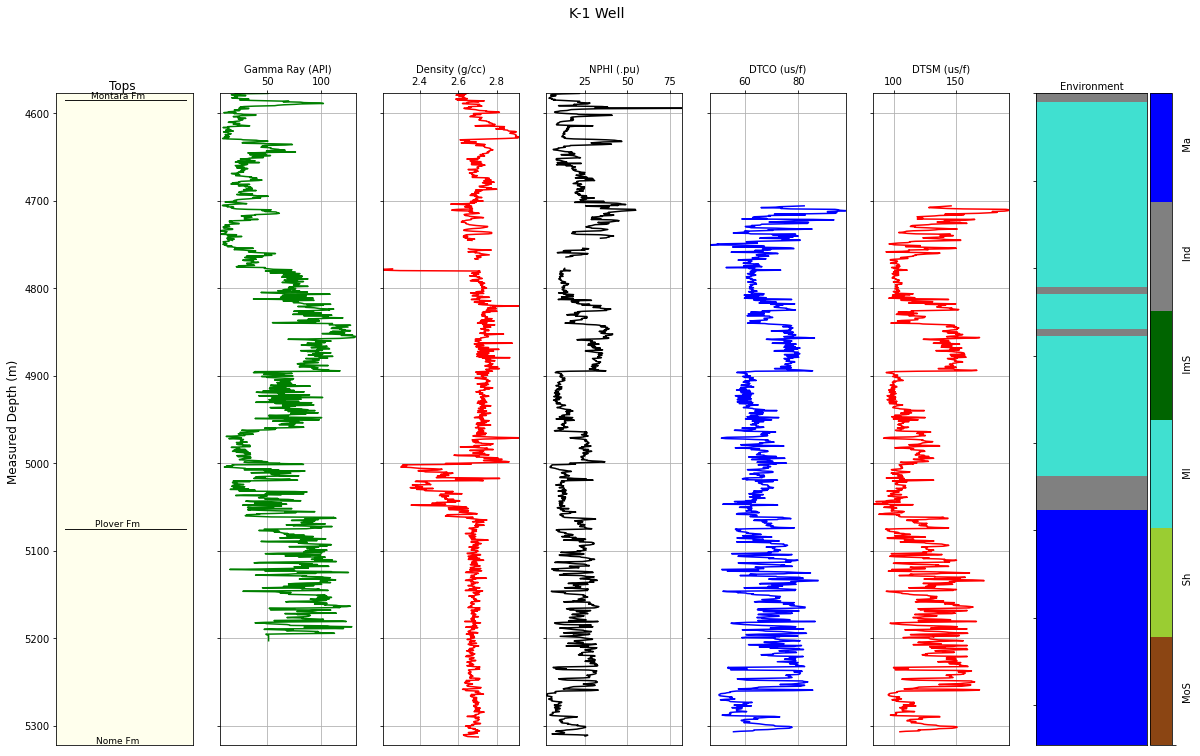

In [ ]:
envplot_data(df, 'K-1')

## Dataset splitting

In [ ]:
df.columns

Index(['Depth', 'Well', 'Formation', 'GR', 'NPHI', 'RHOB', 'DTCO', 'DTSM',
       'Environment'],
      dtype='object')

In [ ]:
X = df.drop(columns=['Depth', 'Well', 'Formation', 'Environment'])
y = df.Environment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2396, 5), (599, 5), (2396,), (599,))

In [ ]:
X.columns

Index(['GR', 'NPHI', 'RHOB', 'DTCO', 'DTSM'], dtype='object')

## Training
- Using KNN model, scaling = standard, 77,4 %

- Using KNN model, scaling = standard, scoring = accuracy, impute = mean, 78.3% (continue to polynomial features)

- Using KNN model, scaling = standard (auto), transform = 'yeo-johnson', impute = mean, scoring = accuracy, 80,1% - final

In [ ]:
X_train.columns

Index(['GR', 'NPHI', 'RHOB', 'DTCO', 'DTSM'], dtype='object')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from jcopml.tuning import grid_search_params as gsp, random_search_params as rsp, bayes_search_params as bsp

from sklearn.metrics import make_scorer

In [ ]:
gsp.knn_params

{'algo__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]),
 'algo__p': [1, 1.5, 2],
 'algo__weights': ['uniform', 'distance']}

In [ ]:
preprocessor = ColumnTransformer([
                                  ('numeric', num_pipe(impute = 'mean', transform= 'yeo-johnson'), X_train.columns)            
])

pipeline = Pipeline([
                     ('prep', preprocessor),
                     ('algo', KNeighborsClassifier())
])

model = GridSearchCV(pipeline, gsp.knn_params, cv= 5, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print('')                      
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 348 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 443 out of 450 | elapsed:   14.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   14.8s finished



{'algo__n_neighbors': 5, 'algo__p': 1.5, 'algo__weights': 'distance'}
0.9987479131886478 0.7612787056367433 0.8013355592654424


### Tuning report

In [ ]:
pd.DataFrame(model.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algo__n_neighbors,param_algo__p,param_algo__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,0.048437,0.003551,0.102865,0.002840,5,1.5,distance,"{'algo__n_neighbors': 5, 'algo__p': 1.5, 'algo...",0.737500,0.784969,0.759916,0.743215,0.780793,0.761279,0.019160,1
25,0.052199,0.001917,0.014592,0.000759,9,1,distance,"{'algo__n_neighbors': 9, 'algo__p': 1, 'algo__...",0.762500,0.770355,0.757829,0.745303,0.770355,0.761268,0.009310,2
13,0.050067,0.001632,0.012637,0.000486,5,1,distance,"{'algo__n_neighbors': 5, 'algo__p': 1, 'algo__...",0.741667,0.784969,0.762004,0.747390,0.766180,0.760442,0.015230,3
19,0.050767,0.002178,0.013923,0.000372,7,1,distance,"{'algo__n_neighbors': 7, 'algo__p': 1, 'algo__...",0.750000,0.782881,0.757829,0.736952,0.772443,0.760021,0.016213,4
31,0.051387,0.002179,0.016037,0.000462,11,1,distance,"{'algo__n_neighbors': 11, 'algo__p': 1, 'algo_...",0.760417,0.766180,0.751566,0.747390,0.774530,0.760017,0.009794,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0.049331,0.001094,0.194948,0.002685,27,1.5,uniform,"{'algo__n_neighbors': 27, 'algo__p': 1.5, 'alg...",0.710417,0.732777,0.722338,0.711900,0.749478,0.725382,0.014493,86
84,0.047378,0.002746,0.038127,0.002641,29,1,uniform,"{'algo__n_neighbors': 29, 'algo__p': 1, 'algo_...",0.712500,0.730689,0.732777,0.707724,0.741127,0.724963,0.012709,87
86,0.046050,0.003236,0.194576,0.002675,29,1.5,uniform,"{'algo__n_neighbors': 29, 'algo__p': 1.5, 'alg...",0.712500,0.726514,0.728601,0.716075,0.734864,0.723711,0.008248,88
82,0.050374,0.003129,0.035214,0.003805,27,2,uniform,"{'algo__n_neighbors': 27, 'algo__p': 2, 'algo_...",0.712500,0.728601,0.728601,0.713987,0.732777,0.723293,0.008359,89


## Feature engineering

### Feature importance

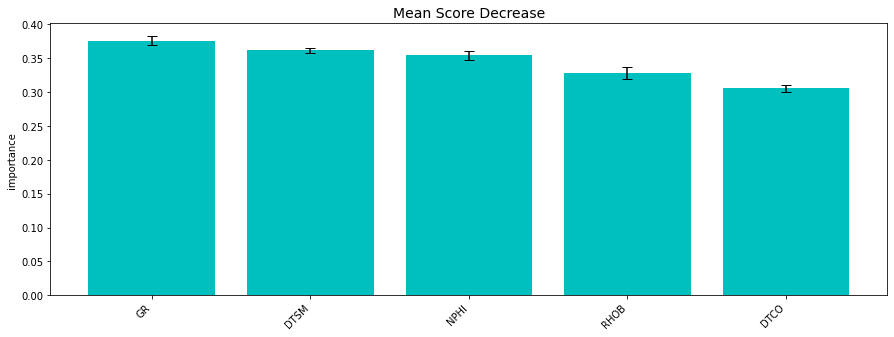

In [ ]:
df_fe = msd(X_train, y_train, model, plot = True, topk=10)

### Polynomial feature
- Using RandomForestClassifier, poly = 2, 78.2%, done

- Using RandomForestClassifier, poly = 2, manual numerical_pipeline, missing values = np.nan, strategi = mean, scaler = standardscaler, scoring = accuracy, 78.4%, done - prefered using KNN

In [ ]:
numerical_pipeline = Pipeline([
                               ('imputer', SimpleImputer(missing_values= np.nan, strategy= 'mean')),
                               ('scaler', StandardScaler()),
                               ('poly', PolynomialFeatures(degree= 2))
])

preprocessor = ColumnTransformer([
                                  ('numeric', numerical_pipeline, ['GR', 'NPHI', 'RHOB', 'DTCO', 'DTSM'])            
])

pipeline = Pipeline([
                     ('prep', preprocessor),
                     ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.rf_poly_params, n_iter = 50, cv= 5, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print('')                      
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.8min finished



{'algo__max_depth': 70, 'algo__max_features': 0.5617270362424192, 'algo__min_samples_leaf': 2, 'algo__n_estimators': 161, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.9841402337228714 0.7733716075156576 0.7846410684474123


## Prediction

### Predict training data

In [ ]:
df['Env_pred'] = model.predict(X)

df.head()

,Depth,Well,Formation,GR,NPHI,RHOB,DTCO,DTSM,Environment,Env_pred
0,4600.0,P-2,Jamieson Fm,66.4510,13.8882,2.5715,81.8708,NaN,4,0
1,4600.5,P-2,Jamieson Fm,54.4524,12.1851,2.5604,78.5466,NaN,4,4
2,4601.0,P-2,Jamieson Fm,51.3234,12.0860,2.5458,81.6343,NaN,4,4
3,4601.5,P-2,Jamieson Fm,49.2121,11.5609,2.5479,78.2709,NaN,4,4
4,4602.0,P-2,Jamieson Fm,68.4992,15.9469,2.5307,79.5989,NaN,4,4


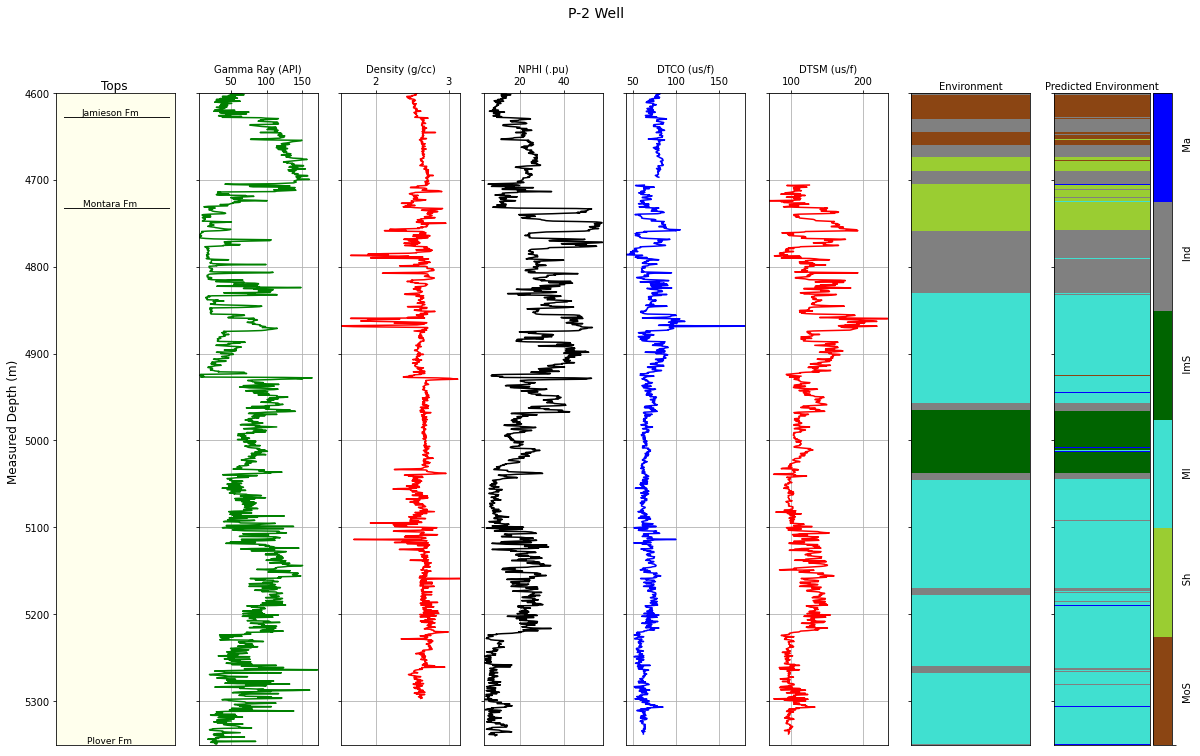

In [ ]:
envplot_val(df, 'P-2')

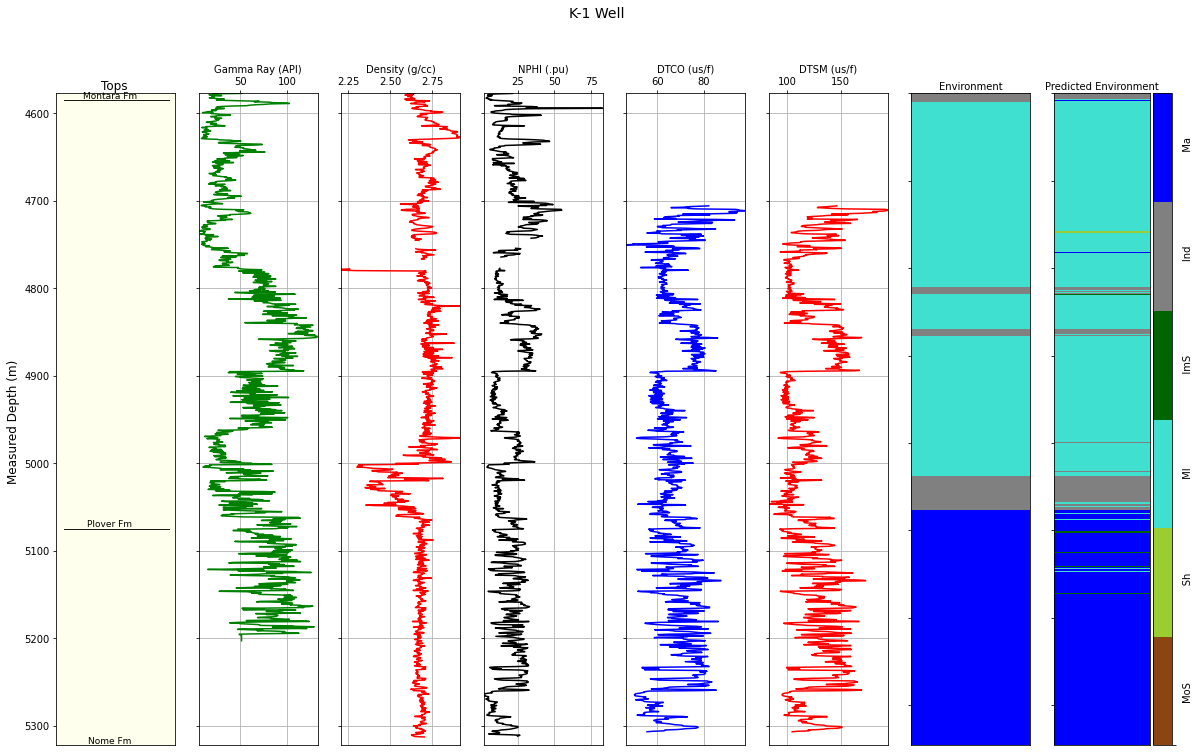

In [ ]:
envplot_val(df, 'K-1')

In [ ]:
# classification report
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        67
           1       1.00      1.00      1.00       111
           2       1.00      1.00      1.00      1319
           3       1.00      1.00      1.00       116
           4       1.00      0.99      1.00       354
           5       0.99      1.00      1.00       429

    accuracy                           1.00      2396
   macro avg       1.00      1.00      1.00      2396
weighted avg       1.00      1.00      1.00      2396


Test report
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        17
           1       0.67      0.43      0.52        28
           2       0.84      0.89      0.87       329
           3       0.74      0.79      0.77        29
           4       0.69      0.56      0.62        89
           5       0.78      0.85      0.81       107

    accuracy                           0.80       5

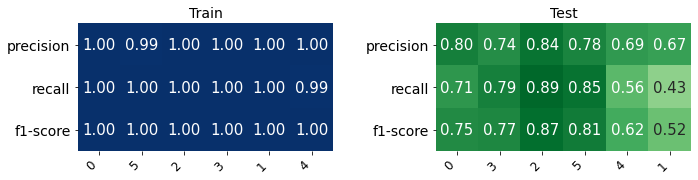

In [ ]:
plot_classification_report(X_train, y_train, X_test, y_test, model)

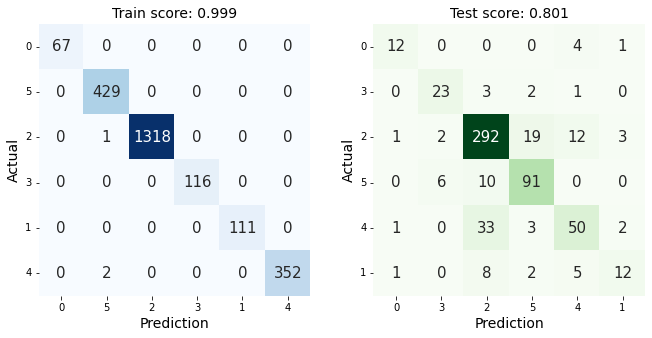

In [ ]:
# confussion matrix
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

### Predict testing data

In [ ]:
df_test = pd.read_csv('boreas.csv', index_col= 0)

df_test = df_test.replace([-999.25], np.nan)

df_test = df_test.replace([df['GR'].max(), np.nan])

df_test.head()

,Depth,Well,Formation,GR,RS,RD,NPHI,RHOB,DTCO,DTSM,Ef_pred,Facies_pred
0,4610.0,B-1,Echuca Shoals Fm,55.3259,1.4348,1.4170,12.04,2.6282,87.4786,NaN,2,4
1,4610.5,B-1,Echuca Shoals Fm,61.7744,1.1341,1.0694,18.93,2.6688,93.8623,NaN,1,2
2,4611.0,B-1,Echuca Shoals Fm,60.9437,1.1748,1.1022,20.12,2.6014,78.9452,NaN,1,2
3,4611.5,B-1,Echuca Shoals Fm,67.9765,1.3287,1.2345,20.01,2.6130,64.5839,NaN,3,5
4,4612.0,B-1,Echuca Shoals Fm,86.1773,1.0648,1.0360,21.62,2.6041,69.4141,NaN,3,1


In [ ]:
df_test.columns

Index(['Depth', 'Well', 'Formation', 'GR', 'RS', 'RD', 'NPHI', 'RHOB', 'DTCO',
       'DTSM', 'Ef_pred', 'Facies_pred'],
      dtype='object')

In [ ]:
X_test = pd.DataFrame(df_test.drop(columns= ['Depth', 'Well', 'Formation', 'RS', 'RD', 'Ef_pred', 'Facies_pred']))

X_test.head()

,GR,NPHI,RHOB,DTCO,DTSM
0,55.3259,12.04,2.6282,87.4786,NaN
1,61.7744,18.93,2.6688,93.8623,NaN
2,60.9437,20.12,2.6014,78.9452,NaN
3,67.9765,20.01,2.6130,64.5839,NaN
4,86.1773,21.62,2.6041,69.4141,NaN


In [ ]:
df_test['Env_pred'] = model.predict(X_test)

df_test.head()

,Depth,Well,Formation,GR,RS,RD,NPHI,RHOB,DTCO,DTSM,Ef_pred,Facies_pred,Env_pred
0,4610.0,B-1,Echuca Shoals Fm,55.3259,1.4348,1.4170,12.04,2.6282,87.4786,NaN,2,4,4
1,4610.5,B-1,Echuca Shoals Fm,61.7744,1.1341,1.0694,18.93,2.6688,93.8623,NaN,1,2,4
2,4611.0,B-1,Echuca Shoals Fm,60.9437,1.1748,1.1022,20.12,2.6014,78.9452,NaN,1,2,2
3,4611.5,B-1,Echuca Shoals Fm,67.9765,1.3287,1.2345,20.01,2.6130,64.5839,NaN,3,5,5
4,4612.0,B-1,Echuca Shoals Fm,86.1773,1.0648,1.0360,21.62,2.6041,69.4141,NaN,3,1,2


In [ ]:
df_test.to_csv()

',Depth,Well,Formation,GR,RS,RD,NPHI,RHOB,DTCO,DTSM,Ef_pred,Facies_pred,Env_pred\n0,4610.0,B-1,Echuca Shoals Fm,55.3259,1.4348,1.4169999999999998,12.04,2.6282,87.4786,,2,4,4\n1,4610.5,B-1,Echuca Shoals Fm,61.7744,1.1341,1.0694,18.93,2.6688,93.8623,,1,2,4\n2,4611.0,B-1,Echuca Shoals Fm,60.9437,1.1748,1.1022,20.12,2.6014,78.9452,,1,2,2\n3,4611.5,B-1,Echuca Shoals Fm,67.9765,1.3287,1.2345,20.01,2.613,64.5839,,3,5,5\n4,4612.0,B-1,Echuca Shoals Fm,86.1773,1.0648,1.036,21.62,2.6041,69.4141,,3,1,2\n5,4612.5,B-1,Echuca Shoals Fm,80.2059,1.3382,1.3263,21.89,2.6021,73.5985,,1,1,2\n6,4613.0,B-1,Echuca Shoals Fm,74.5949,1.6413,1.5482,21.34,2.6164,69.8498,,3,5,5\n7,4613.5,B-1,Echuca Shoals Fm,78.5921,1.3767,1.3519999999999999,21.31,2.6413,91.6138,,1,1,4\n8,4614.0,B-1,Echuca Shoals Fm,83.1176,1.5030000000000001,1.4596,20.82,2.6017,85.3235,,1,1,4\n9,4614.5,B-1,Echuca Shoals Fm,51.7665,1.3676,1.3686,20.89,2.5649,88.2898,,1,4,4\n10,4615.0,B-1,Echuca Shoals Fm,41.7301,3.7995,3.6336,17.08,2.6257,87.7482,

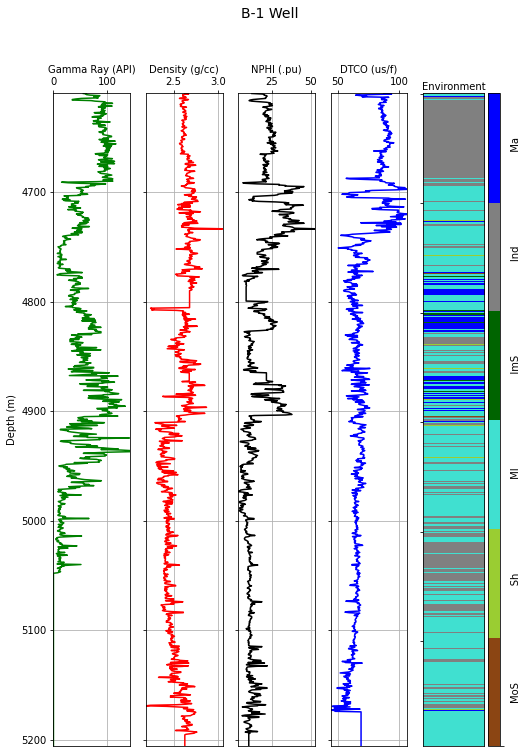

In [ ]:
envplot_test(df_test, 'B-1')

## Save ML model

In [ ]:
save_model(model.best_estimator_, "__________.pkl")

Model is pickled as model/__________.pkl
